In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=3

In [3]:
print FOLD

3


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True,with_l4=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl',
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   ,
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    
                    
                   ])
len(ondate_cols)

36

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy,categorical_feature=[0])
        d_valid = lgb.Dataset(validX, label=validy,categorical_feature=[0])
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.02,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
reload(rrvf_data)

<module 'rrvf_data' from '../python/rrvf2017/rrvf_data.pyc'>

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('l4_3001_lgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199329, 2) (51411, 2)
train/valid # (199329, 2) (51411, 2)
rand split across time
train has 199329 records out of 389630 records
valid has 51411 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1557
0
(199329, 1, 36) (199329, 7, 32) (199329, 1) (199329, 1)
(199329, 260) (199329,) (199329,)
(51411, 1, 36) (51411, 7, 32) (51411, 1) (51411, 1)
(51411, 260) (51411,) (51411,)
(5803, 1, 36) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 260) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf': 0.001, 'b

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:1030: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:671: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's rmse: 0.776116
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.767043
[3]	valid_0's rmse: 0.758301
[4]	valid_0's rmse: 0.749769
[5]	valid_0's rmse: 0.741562
[6]	valid_0's rmse: 0.733566
[7]	valid_0's rmse: 0.725798
[8]	valid_0's rmse: 0.718175
[9]	valid_0's rmse: 0.710776
[10]	valid_0's rmse: 0.703624
[11]	valid_0's rmse: 0.696675
[12]	valid_0's rmse: 0.689987
[13]	valid_0's rmse: 0.683436
[14]	valid_0's rmse: 0.677091
[15]	valid_0's rmse: 0.670993
[16]	valid_0's rmse: 0.665071
[17]	valid_0's rmse: 0.65929
[18]	valid_0's rmse: 0.653688
[19]	valid_0's rmse: 0.648262
[20]	valid_0's rmse: 0.643073
[21]	valid_0's rmse: 0.637978
[22]	valid_0's rmse: 0.633104
[23]	valid_0's rmse: 0.628395
[24]	valid_0's rmse: 0.623842
[25]	valid_0's rmse: 0.619381
[26]	valid_0's rmse: 0.6151
[27]	valid_0's rmse: 0.61091
[28]	valid_0's rmse: 0.606916
[29]	valid_0's rmse: 0.60307
[30]	valid_0's rmse: 0.599344
[31]	valid_0's rmse: 0.59572
[32]	valid_0's rmse: 0.

[269]	valid_0's rmse: 0.500042
[270]	valid_0's rmse: 0.500036
[271]	valid_0's rmse: 0.500048
[272]	valid_0's rmse: 0.500048
[273]	valid_0's rmse: 0.500058
[274]	valid_0's rmse: 0.500067
[275]	valid_0's rmse: 0.500061
[276]	valid_0's rmse: 0.500072
[277]	valid_0's rmse: 0.500068
[278]	valid_0's rmse: 0.500076
[279]	valid_0's rmse: 0.500084
[280]	valid_0's rmse: 0.500088
[281]	valid_0's rmse: 0.500082
[282]	valid_0's rmse: 0.500083
[283]	valid_0's rmse: 0.500082
[284]	valid_0's rmse: 0.500082
[285]	valid_0's rmse: 0.500085
[286]	valid_0's rmse: 0.500089
[287]	valid_0's rmse: 0.500083
[288]	valid_0's rmse: 0.500082
[289]	valid_0's rmse: 0.50009
[290]	valid_0's rmse: 0.500099
[291]	valid_0's rmse: 0.500087
[292]	valid_0's rmse: 0.500083
[293]	valid_0's rmse: 0.500083
[294]	valid_0's rmse: 0.500076
[295]	valid_0's rmse: 0.500066
Early stopping, best iteration is:
[245]	valid_0's rmse: 0.499968
0.2189392961890104 0.24996806987987913
[0.24996806987987913]
-1 mean score 0.24996806987987913
0.1

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.924812  0.004298  0.203445    7  2017-04-16
472     2.507290  2.540477 -0.033187  0.211559    1  2017-04-17
473     2.661330  2.668540 -0.007210  0.234327    2  2017-04-18
474     2.754815  2.744943  0.009872  0.192127    3  2017-04-19
475     2.713762  2.712482  0.001279  0.217513    4  2017-04-20
476     2.999000  2.982367  0.016633  0.146863    5  2017-04-21
477     3.075529  3.078753 -0.003223  0.173667    6  2017-04-22

0.197071690753


pred         y     error    error2  day        date
dayidx                                                         
471     2.924812  2.929110  0.004298  0.203445    7  2017-04-16
472     2.540477  2.507290 -0.033187  0.211559    1  2017-04-17
473     2.668540  2.661330 -0.007210  0.234327    2  2017-04-18
474     2.744943  2.754815  0.009872  0.192127    3  2017-04-19
475     2.712482  2.713762  0.001279  0.217513    4  2017-04-20
476     2.982367  2.999000  0.016633  0.146863    5  2017-04-21
477     3.078753  3.075529 -0.003223  0.173667    6  2017-04-22

(829, 260)


2
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199102, 2) (51355, 2)
train/valid # (199102, 2) (51355, 2)
rand split across time
train has 199102 records out of 389630 records
valid has 51355 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1555
0
(199102, 1, 36) (199102, 7, 32) (199102, 1) (199102, 1)
(199102, 260) (199102,) (199102,)
(51355, 1, 36) (51355, 7, 32) (51355, 1) (51355, 1)
(51355, 260) (51355,) (51355,)
(6632, 1, 36) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 260) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[235]	valid_0's rmse: 0.506653
[236]	valid_0's rmse: 0.506664
[237]	valid_0's rmse: 0.506667
[238]	valid_0's rmse: 0.506669
[239]	valid_0's rmse: 0.506687
[240]	valid_0's rmse: 0.506687
[241]	valid_0's rmse: 0.506696
[242]	valid_0's rmse: 0.506696
[243]	valid_0's rmse: 0.506692
[244]	valid_0's rmse: 0.506691
[245]	valid_0's rmse: 0.506681
[246]	valid_0's rmse: 0.506679
[247]	valid_0's rmse: 0.506676
[248]	valid_0's rmse: 0.506688
[249]	valid_0's rmse: 0.506695
[250]	valid_0's rmse: 0.506716
[251]	valid_0's rmse: 0.506725
[252]	valid_0's rmse: 0.506735
[253]	valid_0's rmse: 0.506741
[254]	valid_0's rmse: 0.50675
[255]	valid_0's rmse: 0.506756
[256]	valid_0's rmse: 0.506764
[257]	valid_0's rmse: 0.506756
[258]	valid_0's rmse: 0.506757
[259]	valid_0's rmse: 0.506758
Early stopping, best iteration is:
[209]	valid_0's rmse: 0.506609
0.22788693595348472 0.2566530551953475
[0.2566530551953475]
-1 mean score 0.2566530551953475
0.205057587843


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918308  0.010802  0.217776    7  2017-04-16
472     2.507290  2.536600 -0.029310  0.217437    1  2017-04-17
473     2.661330  2.663577 -0.002247  0.240383    2  2017-04-18
474     2.754815  2.738818  0.015997  0.204437    3  2017-04-19
475     2.713762  2.717638 -0.003876  0.228104    4  2017-04-20
476     2.999000  2.989379  0.009621  0.151666    5  2017-04-21
477     3.075529  3.068262  0.007267  0.175600    6  2017-04-22

0.205057587843


pred         y     error    error2  day        date
dayidx                                                         
471     2.918308  2.929110  0.010802  0.217776    7  2017-04-16
472     2.536600  2.507290 -0.029310  0.217437    1  2017-04-17
473     2.663577  2.661330 -0.002247  0.240383    2  2017-04-18
474     2.738818  2.754815  0.015997  0.204437    3  2017-04-19
475     2.717638  2.713762 -0.003876  0.228104    4  2017-04-20
476     2.989379  2.999000  0.009621  0.151666    5  2017-04-21
477     3.068262  3.075529  0.007267  0.175600    6  2017-04-22

(829, 260)


3
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198922, 2) (51308, 2)
train/valid # (198922, 2) (51308, 2)
rand split across time
train has 198922 records out of 389630 records
valid has 51308 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1554
0
(198922, 1, 36) (198922, 7, 32) (198922, 1) (198922, 1)
(198922, 260) (198922,) (198922,)
(51308, 1, 36) (51308, 7, 32) (51308, 1) (51308, 1)
(51308, 260) (51308,) (51308,)
(7461, 1, 36) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 260) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[236]	valid_0's rmse: 0.508471
[237]	valid_0's rmse: 0.508478
[238]	valid_0's rmse: 0.508479
[239]	valid_0's rmse: 0.508484
[240]	valid_0's rmse: 0.508493
[241]	valid_0's rmse: 0.508497
[242]	valid_0's rmse: 0.508506
[243]	valid_0's rmse: 0.508513
[244]	valid_0's rmse: 0.508518
[245]	valid_0's rmse: 0.508527
[246]	valid_0's rmse: 0.508533
[247]	valid_0's rmse: 0.50853
[248]	valid_0's rmse: 0.508528
[249]	valid_0's rmse: 0.508547
[250]	valid_0's rmse: 0.508546
[251]	valid_0's rmse: 0.508554
[252]	valid_0's rmse: 0.508558
[253]	valid_0's rmse: 0.508562
Early stopping, best iteration is:
[203]	valid_0's rmse: 0.508371
0.23052698863629353 0.25844105776817716
[0.25844105776817716]
-1 mean score 0.25844105776817716
0.209062755199


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902462  0.026648  0.219404    7  2017-04-16
472     2.507290  2.535390 -0.028099  0.220313    1  2017-04-17
473     2.661330  2.652180  0.009149  0.252143    2  2017-04-18
474     2.754815  2.754519  0.000295  0.210820    3  2017-04-19
475     2.713762  2.716554 -0.002792  0.229000    4  2017-04-20
476     2.999000  2.988329  0.010670  0.153389    5  2017-04-21
477     3.075529  3.067680  0.007849  0.178371    6  2017-04-22

0.209062755199


pred         y     error    error2  day        date
dayidx                                                         
471     2.902462  2.929110  0.026648  0.219404    7  2017-04-16
472     2.535390  2.507290 -0.028099  0.220313    1  2017-04-17
473     2.652180  2.661330  0.009149  0.252143    2  2017-04-18
474     2.754519  2.754815  0.000295  0.210820    3  2017-04-19
475     2.716554  2.713762 -0.002792  0.229000    4  2017-04-20
476     2.988329  2.999000  0.010670  0.153389    5  2017-04-21
477     3.067680  3.075529  0.007849  0.178371    6  2017-04-22

(829, 260)


4
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198759, 2) (51269, 2)
train/valid # (198759, 2) (51269, 2)
rand split across time
train has 198759 records out of 389630 records
valid has 51269 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1552
0
(198759, 1, 36) (198759, 7, 32) (198759, 1) (198759, 1)
(198759, 260) (198759,) (198759,)
(51269, 1, 36) (51269, 7, 32) (51269, 1) (51269, 1)
(51269, 260) (51269,) (51269,)
(8290, 1, 36) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 260) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[236]	valid_0's rmse: 0.51042
[237]	valid_0's rmse: 0.510421
[238]	valid_0's rmse: 0.510427
[239]	valid_0's rmse: 0.510431
[240]	valid_0's rmse: 0.510446
[241]	valid_0's rmse: 0.510451
[242]	valid_0's rmse: 0.510448
[243]	valid_0's rmse: 0.51045
[244]	valid_0's rmse: 0.510444
[245]	valid_0's rmse: 0.510448
[246]	valid_0's rmse: 0.510458
[247]	valid_0's rmse: 0.510464
[248]	valid_0's rmse: 0.510471
[249]	valid_0's rmse: 0.510488
[250]	valid_0's rmse: 0.510492
[251]	valid_0's rmse: 0.510504
[252]	valid_0's rmse: 0.510506
[253]	valid_0's rmse: 0.510513
[254]	valid_0's rmse: 0.510516
Early stopping, best iteration is:
[204]	valid_0's rmse: 0.510322
0.23181833560765416 0.26042888081113896
[0.26042888081113896]
-1 mean score 0.26042888081113896
0.208129670269


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901369  0.027741  0.222062    7  2017-04-16
472     2.507290  2.526610 -0.019319  0.220492    1  2017-04-17
473     2.661330  2.645160  0.016170  0.245975    2  2017-04-18
474     2.754815  2.740757  0.014058  0.206452    3  2017-04-19
475     2.713762  2.715512 -0.001750  0.229812    4  2017-04-20
476     2.999000  2.977021  0.021979  0.156361    5  2017-04-21
477     3.075529  3.063588  0.011941  0.175753    6  2017-04-22

0.208129670269


pred         y     error    error2  day        date
dayidx                                                         
471     2.901369  2.929110  0.027741  0.222062    7  2017-04-16
472     2.526610  2.507290 -0.019319  0.220492    1  2017-04-17
473     2.645160  2.661330  0.016170  0.245975    2  2017-04-18
474     2.740757  2.754815  0.014058  0.206452    3  2017-04-19
475     2.715512  2.713762 -0.001750  0.229812    4  2017-04-20
476     2.977021  2.999000  0.021979  0.156361    5  2017-04-21
477     3.063588  3.075529  0.011941  0.175753    6  2017-04-22

(829, 260)


5
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198558, 2) (51218, 2)
train/valid # (198558, 2) (51218, 2)
rand split across time
train has 198558 records out of 389630 records
valid has 51218 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1551
0
(198558, 1, 36) (198558, 7, 32) (198558, 1) (198558, 1)
(198558, 260) (198558,) (198558,)
(51218, 1, 36) (51218, 7, 32) (51218, 1) (51218, 1)
(51218, 260) (51218,) (51218,)
(9119, 1, 36) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 260) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[236]	valid_0's rmse: 0.511342
[237]	valid_0's rmse: 0.511342
[238]	valid_0's rmse: 0.511355
[239]	valid_0's rmse: 0.511369
[240]	valid_0's rmse: 0.511377
[241]	valid_0's rmse: 0.511388
[242]	valid_0's rmse: 0.511404
[243]	valid_0's rmse: 0.51141
[244]	valid_0's rmse: 0.511422
[245]	valid_0's rmse: 0.51143
Early stopping, best iteration is:
[195]	valid_0's rmse: 0.51128
0.234487517057735 0.2614076734092258
[0.2614076734092258]
-1 mean score 0.2614076734092258
0.211022910058


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905710  0.023400  0.223028    7  2017-04-16
472     2.507290  2.536877 -0.029587  0.225524    1  2017-04-17
473     2.661330  2.635836  0.025494  0.249100    2  2017-04-18
474     2.754815  2.735397  0.019418  0.206504    3  2017-04-19
475     2.713762  2.712353  0.001408  0.234169    4  2017-04-20
476     2.999000  2.976311  0.022689  0.160298    5  2017-04-21
477     3.075529  3.067322  0.008208  0.178538    6  2017-04-22

0.211022910058


pred         y     error    error2  day        date
dayidx                                                         
471     2.905710  2.929110  0.023400  0.223028    7  2017-04-16
472     2.536877  2.507290 -0.029587  0.225524    1  2017-04-17
473     2.635836  2.661330  0.025494  0.249100    2  2017-04-18
474     2.735397  2.754815  0.019418  0.206504    3  2017-04-19
475     2.712353  2.713762  0.001408  0.234169    4  2017-04-20
476     2.976311  2.999000  0.022689  0.160298    5  2017-04-21
477     3.067322  3.075529  0.008208  0.178538    6  2017-04-22

(829, 260)


6
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 15.133374
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198349, 2) (51164, 2)
train/valid # (198349, 2) (51164, 2)
rand split across time
train has 198349 records out of 389630 records
valid has 51164 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1549
0
(198349, 1, 36) (198349, 7, 32) (198349, 1) (198349, 1)
(198349, 260) (198349,) (198349,)
(51164, 1, 36) (51164, 7, 32) (51164, 1) (51164, 1)
(51164, 260) (51164,) (51164,)
(9948, 1, 36) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 260) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_in_leaf'

[235]	valid_0's rmse: 0.512883
[236]	valid_0's rmse: 0.512875
[237]	valid_0's rmse: 0.512882
[238]	valid_0's rmse: 0.512889
[239]	valid_0's rmse: 0.512881
[240]	valid_0's rmse: 0.512887
[241]	valid_0's rmse: 0.512885
[242]	valid_0's rmse: 0.512897
[243]	valid_0's rmse: 0.512895
[244]	valid_0's rmse: 0.512895
[245]	valid_0's rmse: 0.512884
[246]	valid_0's rmse: 0.512888
[247]	valid_0's rmse: 0.512897
[248]	valid_0's rmse: 0.512898
[249]	valid_0's rmse: 0.512894
[250]	valid_0's rmse: 0.512907
[251]	valid_0's rmse: 0.512925
[252]	valid_0's rmse: 0.512932
[253]	valid_0's rmse: 0.512933
[254]	valid_0's rmse: 0.512942
[255]	valid_0's rmse: 0.512949
[256]	valid_0's rmse: 0.512954
[257]	valid_0's rmse: 0.512962
[258]	valid_0's rmse: 0.512963
[259]	valid_0's rmse: 0.512968
[260]	valid_0's rmse: 0.512968
[261]	valid_0's rmse: 0.512969
[262]	valid_0's rmse: 0.51296
[263]	valid_0's rmse: 0.512956
[264]	valid_0's rmse: 0.512957
[265]	valid_0's rmse: 0.512968
[266]	valid_0's rmse: 0.512954
[267]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913157  0.015953  0.225533    7  2017-04-16
472     2.507290  2.543869 -0.036579  0.231240    1  2017-04-17
473     2.661330  2.639707  0.021623  0.253336    2  2017-04-18
474     2.754815  2.734820  0.019994  0.204527    3  2017-04-19
475     2.713762  2.720095 -0.006334  0.234386    4  2017-04-20
476     2.999000  2.971844  0.027155  0.157316    5  2017-04-21
477     3.075529  3.078569 -0.003040  0.179189    6  2017-04-22

0.212218172838


pred         y     error    error2  day        date
dayidx                                                         
471     2.913157  2.929110  0.015953  0.225533    7  2017-04-16
472     2.543869  2.507290 -0.036579  0.231240    1  2017-04-17
473     2.639707  2.661330  0.021623  0.253336    2  2017-04-18
474     2.734820  2.754815  0.019994  0.204527    3  2017-04-19
475     2.720095  2.713762 -0.006334  0.234386    4  2017-04-20
476     2.971844  2.999000  0.027155  0.157316    5  2017-04-21
477     3.078569  3.075529 -0.003040  0.179189    6  2017-04-22

(829, 260)


7
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 16.310143
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198132, 2) (51107, 2)
train/valid # (198132, 2) (51107, 2)
rand split across time
train has 198132 records out of 389630 records
valid has 51107 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1547
0
(198132, 1, 36) (198132, 7, 32) (198132, 1) (198132, 1)
(198132, 260) (198132,) (198132,)
(51107, 1, 36) (51107, 7, 32) (51107, 1) (51107, 1)
(51107, 260) (51107,) (51107,)
(10777, 1, 36) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 260) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.514841
[236]	valid_0's rmse: 0.514847
[237]	valid_0's rmse: 0.514856
[238]	valid_0's rmse: 0.514882
[239]	valid_0's rmse: 0.514896
[240]	valid_0's rmse: 0.514902
[241]	valid_0's rmse: 0.5149
Early stopping, best iteration is:
[191]	valid_0's rmse: 0.514581
0.23765019219162967 0.2647932528614968
[0.2647932528614968]
-1 mean score 0.2647932528614968
0.215843435636


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906891  0.022218  0.228051    7  2017-04-16
472     2.507290  2.555229 -0.047939  0.235006    1  2017-04-17
473     2.661330  2.650464  0.010866  0.259030    2  2017-04-18
474     2.754815  2.732802  0.022013  0.208201    3  2017-04-19
475     2.713762  2.715839 -0.002078  0.238158    4  2017-04-20
476     2.999000  2.976456  0.022544  0.157681    5  2017-04-21
477     3.075529  3.087611 -0.012082  0.184778    6  2017-04-22

0.215843435636


pred         y     error    error2  day        date
dayidx                                                         
471     2.906891  2.929110  0.022218  0.228051    7  2017-04-16
472     2.555229  2.507290 -0.047939  0.235006    1  2017-04-17
473     2.650464  2.661330  0.010866  0.259030    2  2017-04-18
474     2.732802  2.754815  0.022013  0.208201    3  2017-04-19
475     2.715839  2.713762 -0.002078  0.238158    4  2017-04-20
476     2.976456  2.999000  0.022544  0.157681    5  2017-04-21
477     3.087611  3.075529 -0.012082  0.184778    6  2017-04-22

(829, 260)


8
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 17.574337
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197899, 2) (51050, 2)
train/valid # (197899, 2) (51050, 2)
rand split across time
train has 197899 records out of 389630 records
valid has 51050 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1546
0
(197899, 1, 36) (197899, 7, 32) (197899, 1) (197899, 1)
(197899, 260) (197899,) (197899,)
(51050, 1, 36) (51050, 7, 32) (51050, 1) (51050, 1)
(51050, 260) (51050,) (51050,)
(11606, 1, 36) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 260) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[235]	valid_0's rmse: 0.517173
[236]	valid_0's rmse: 0.517185
Early stopping, best iteration is:
[186]	valid_0's rmse: 0.516845
0.2417201295899454 0.2671291036134978
[0.2671291036134978]
-1 mean score 0.2671291036134978
0.220019065896


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920509  0.008601  0.234120    7  2017-04-16
472     2.507290  2.553012 -0.045722  0.234911    1  2017-04-17
473     2.661330  2.652883  0.008447  0.259326    2  2017-04-18
474     2.754815  2.736937  0.017878  0.219061    3  2017-04-19
475     2.713762  2.716453 -0.002692  0.240299    4  2017-04-20
476     2.999000  2.966122  0.032878  0.167302    5  2017-04-21
477     3.075529  3.084763 -0.009233  0.185114    6  2017-04-22

0.220019065896


pred         y     error    error2  day        date
dayidx                                                         
471     2.920509  2.929110  0.008601  0.234120    7  2017-04-16
472     2.553012  2.507290 -0.045722  0.234911    1  2017-04-17
473     2.652883  2.661330  0.008447  0.259326    2  2017-04-18
474     2.736937  2.754815  0.017878  0.219061    3  2017-04-19
475     2.716453  2.713762 -0.002692  0.240299    4  2017-04-20
476     2.966122  2.999000  0.032878  0.167302    5  2017-04-21
477     3.084763  3.075529 -0.009233  0.185114    6  2017-04-22

(829, 260)


9
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 18.806503
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197673, 2) (50994, 2)
train/valid # (197673, 2) (50994, 2)
rand split across time
train has 197673 records out of 389630 records
valid has 50994 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1544
0
(197673, 1, 36) (197673, 7, 32) (197673, 1) (197673, 1)
(197673, 260) (197673,) (197673,)
(50994, 1, 36) (50994, 7, 32) (50994, 1) (50994, 1)
(50994, 260) (50994,) (50994,)
(12435, 1, 36) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 260) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

0.24392295341234158 0.2708964152226993
[0.2708964152226993]
-1 mean score 0.2708964152226993
0.220845563896


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914176  0.014934  0.238737    7  2017-04-16
472     2.507290  2.560429 -0.053138  0.232521    1  2017-04-17
473     2.661330  2.666750 -0.005420  0.265047    2  2017-04-18
474     2.754815  2.732635  0.022180  0.222449    3  2017-04-19
475     2.713762  2.718824 -0.005062  0.237464    4  2017-04-20
476     2.999000  2.966514  0.032486  0.165227    5  2017-04-21
477     3.075529  3.076075 -0.000546  0.184475    6  2017-04-22

0.220845563896


pred         y     error    error2  day        date
dayidx                                                         
471     2.914176  2.929110  0.014934  0.238737    7  2017-04-16
472     2.560429  2.507290 -0.053138  0.232521    1  2017-04-17
473     2.666750  2.661330 -0.005420  0.265047    2  2017-04-18
474     2.732635  2.754815  0.022180  0.222449    3  2017-04-19
475     2.718824  2.713762 -0.005062  0.237464    4  2017-04-20
476     2.966514  2.999000  0.032486  0.165227    5  2017-04-21
477     3.076075  3.075529 -0.000546  0.184475    6  2017-04-22

(829, 260)


10
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 19.926521
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197500, 2) (50951, 2)
train/valid # (197500, 2) (50951, 2)
rand split across time
train has 197500 records out of 389630 records
valid has 50951 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1542
0
(197500, 1, 36) (197500, 7, 32) (197500, 1) (197500, 1)
(197500, 260) (197500,) (197500,)
(50951, 1, 36) (50951, 7, 32) (50951, 1) (50951, 1)
(50951, 260) (50951,) (50951,)
(13264, 1, 36) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 260) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

[234]	valid_0's rmse: 0.521089
[235]	valid_0's rmse: 0.521089
[236]	valid_0's rmse: 0.521106
[237]	valid_0's rmse: 0.521124
Early stopping, best iteration is:
[187]	valid_0's rmse: 0.520847
0.24437566708108885 0.27128111197007887
[0.27128111197007887]
-1 mean score 0.27128111197007887
0.220067998878


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911060  0.018050  0.234808    7  2017-04-16
472     2.507290  2.549327 -0.042037  0.232994    1  2017-04-17
473     2.661330  2.666589 -0.005260  0.263843    2  2017-04-18
474     2.754815  2.740504  0.014311  0.219352    3  2017-04-19
475     2.713762  2.721819 -0.008057  0.239140    4  2017-04-20
476     2.999000  2.970768  0.028231  0.164449    5  2017-04-21
477     3.075529  3.080073 -0.004544  0.185889    6  2017-04-22

0.220067998878


pred         y     error    error2  day        date
dayidx                                                         
471     2.911060  2.929110  0.018050  0.234808    7  2017-04-16
472     2.549327  2.507290 -0.042037  0.232994    1  2017-04-17
473     2.666589  2.661330 -0.005260  0.263843    2  2017-04-18
474     2.740504  2.754815  0.014311  0.219352    3  2017-04-19
475     2.721819  2.713762 -0.008057  0.239140    4  2017-04-20
476     2.970768  2.999000  0.028231  0.164449    5  2017-04-21
477     3.080073  3.075529 -0.004544  0.185889    6  2017-04-22

(829, 260)


11
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 21.05768
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197318, 2) (50907, 2)
train/valid # (197318, 2) (50907, 2)
rand split across time
train has 197318 records out of 389630 records
valid has 50907 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1541
0
(197318, 1, 36) (197318, 7, 32) (197318, 1) (197318, 1)
(197318, 260) (197318,) (197318,)
(50907, 1, 36) (50907, 7, 32) (50907, 1) (50907, 1)
(50907, 260) (50907,) (50907,)
(14093, 1, 36) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 260) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

[234]	valid_0's rmse: 0.522548
[235]	valid_0's rmse: 0.522559
[236]	valid_0's rmse: 0.522568
[237]	valid_0's rmse: 0.522563
[238]	valid_0's rmse: 0.522554
Early stopping, best iteration is:
[188]	valid_0's rmse: 0.522302
0.2450725267455822 0.27279895322556424
[0.27279895322556424]
-1 mean score 0.27279895322556424
0.221061045282


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897472  0.031638  0.233537    7  2017-04-16
472     2.507290  2.549941 -0.042650  0.234168    1  2017-04-17
473     2.661330  2.663894 -0.002564  0.267230    2  2017-04-18
474     2.754815  2.728046  0.026768  0.219806    3  2017-04-19
475     2.713762  2.728567 -0.014805  0.237949    4  2017-04-20
476     2.999000  2.973510  0.025489  0.168744    5  2017-04-21
477     3.075529  3.065076  0.010453  0.185993    6  2017-04-22

0.221061045282


pred         y     error    error2  day        date
dayidx                                                         
471     2.897472  2.929110  0.031638  0.233537    7  2017-04-16
472     2.549941  2.507290 -0.042650  0.234168    1  2017-04-17
473     2.663894  2.661330 -0.002564  0.267230    2  2017-04-18
474     2.728046  2.754815  0.026768  0.219806    3  2017-04-19
475     2.728567  2.713762 -0.014805  0.237949    4  2017-04-20
476     2.973510  2.999000  0.025489  0.168744    5  2017-04-21
477     3.065076  3.075529  0.010453  0.185993    6  2017-04-22

(829, 260)


12
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 22.115147
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197106, 2) (50852, 2)
train/valid # (197106, 2) (50852, 2)
rand split across time
train has 197106 records out of 389630 records
valid has 50852 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1539
0
(197106, 1, 36) (197106, 7, 32) (197106, 1) (197106, 1)
(197106, 260) (197106,) (197106,)
(50852, 1, 36) (50852, 7, 32) (50852, 1) (50852, 1)
(50852, 260) (50852,) (50852,)
(14922, 1, 36) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 260) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

0.24716232305078853 0.2736194072685795
[0.2736194072685795]
-1 mean score 0.2736194072685795
0.22335637991


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895272  0.033838  0.241743    7  2017-04-16
472     2.507290  2.554267 -0.046977  0.235462    1  2017-04-17
473     2.661330  2.665880 -0.004551  0.268628    2  2017-04-18
474     2.754815  2.726604  0.028211  0.223428    3  2017-04-19
475     2.713762  2.719717 -0.005956  0.238614    4  2017-04-20
476     2.999000  2.968690  0.030310  0.169151    5  2017-04-21
477     3.075529  3.068972  0.006557  0.186468    6  2017-04-22

0.22335637991


pred         y     error    error2  day        date
dayidx                                                         
471     2.895272  2.929110  0.033838  0.241743    7  2017-04-16
472     2.554267  2.507290 -0.046977  0.235462    1  2017-04-17
473     2.665880  2.661330 -0.004551  0.268628    2  2017-04-18
474     2.726604  2.754815  0.028211  0.223428    3  2017-04-19
475     2.719717  2.713762 -0.005956  0.238614    4  2017-04-20
476     2.968690  2.999000  0.030310  0.169151    5  2017-04-21
477     3.068972  3.075529  0.006557  0.186468    6  2017-04-22

(829, 260)


13
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 23.15517
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196898, 2) (50797, 2)
train/valid # (196898, 2) (50797, 2)
rand split across time
train has 196898 records out of 389630 records
valid has 50797 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1538
0
(196898, 1, 36) (196898, 7, 32) (196898, 1) (196898, 1)
(196898, 260) (196898,) (196898,)
(50797, 1, 36) (50797, 7, 32) (50797, 1) (50797, 1)
(50797, 260) (50797,) (50797,)
(15751, 1, 36) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 260) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

0.24743546410046788 0.2744757983656991
[0.2744757983656991]
-1 mean score 0.2744757983656991
0.222696049218


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902248  0.026862  0.240808    7  2017-04-16
472     2.507290  2.550370 -0.043080  0.238364    1  2017-04-17
473     2.661330  2.669419 -0.008089  0.265549    2  2017-04-18
474     2.754815  2.732849  0.021966  0.224045    3  2017-04-19
475     2.713762  2.726275 -0.012513  0.242199    4  2017-04-20
476     2.999000  2.976031  0.022969  0.165510    5  2017-04-21
477     3.075529  3.060991  0.014538  0.182397    6  2017-04-22

0.222696049218


pred         y     error    error2  day        date
dayidx                                                         
471     2.902248  2.929110  0.026862  0.240808    7  2017-04-16
472     2.550370  2.507290 -0.043080  0.238364    1  2017-04-17
473     2.669419  2.661330 -0.008089  0.265549    2  2017-04-18
474     2.732849  2.754815  0.021966  0.224045    3  2017-04-19
475     2.726275  2.713762 -0.012513  0.242199    4  2017-04-20
476     2.976031  2.999000  0.022969  0.165510    5  2017-04-21
477     3.060991  3.075529  0.014538  0.182397    6  2017-04-22

(829, 260)


14
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 24.22639
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196676, 2) (50741, 2)
train/valid # (196676, 2) (50741, 2)
rand split across time
train has 196676 records out of 389630 records
valid has 50741 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1536
0
(196676, 1, 36) (196676, 7, 32) (196676, 1) (196676, 1)
(196676, 260) (196676,) (196676,)
(50741, 1, 36) (50741, 7, 32) (50741, 1) (50741, 1)
(50741, 260) (50741,) (50741,)
(16580, 1, 36) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 260) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

0.24852090542992764 0.2754585574256808
[0.2754585574256808]
-1 mean score 0.2754585574256808
0.223691694836


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894715  0.034395  0.245178    7  2017-04-16
472     2.507290  2.545265 -0.037975  0.236428    1  2017-04-17
473     2.661330  2.665437 -0.004107  0.267307    2  2017-04-18
474     2.754815  2.724675  0.030140  0.228384    3  2017-04-19
475     2.713762  2.724849 -0.011088  0.238062    4  2017-04-20
476     2.999000  2.987085  0.011914  0.163154    5  2017-04-21
477     3.075529  3.070762  0.004767  0.187329    6  2017-04-22

0.223691694836


pred         y     error    error2  day        date
dayidx                                                         
471     2.894715  2.929110  0.034395  0.245178    7  2017-04-16
472     2.545265  2.507290 -0.037975  0.236428    1  2017-04-17
473     2.665437  2.661330 -0.004107  0.267307    2  2017-04-18
474     2.724675  2.754815  0.030140  0.228384    3  2017-04-19
475     2.724849  2.713762 -0.011088  0.238062    4  2017-04-20
476     2.987085  2.999000  0.011914  0.163154    5  2017-04-21
477     3.070762  3.075529  0.004767  0.187329    6  2017-04-22

(829, 260)


15
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 25.357664
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196445, 2) (50682, 2)
train/valid # (196445, 2) (50682, 2)
rand split across time
train has 196445 records out of 389630 records
valid has 50682 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1534
0
(196445, 1, 36) (196445, 7, 32) (196445, 1) (196445, 1)
(196445, 260) (196445,) (196445,)
(50682, 1, 36) (50682, 7, 32) (50682, 1) (50682, 1)
(50682, 260) (50682,) (50682,)
(17409, 1, 36) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 260) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910312  0.018798  0.249492    7  2017-04-16
472     2.507290  2.549130 -0.041840  0.240281    1  2017-04-17
473     2.661330  2.660388  0.000942  0.277841    2  2017-04-18
474     2.754815  2.724874  0.029941  0.224962    3  2017-04-19
475     2.713762  2.728775 -0.015014  0.246207    4  2017-04-20
476     2.999000  2.986966  0.012033  0.168883    5  2017-04-21
477     3.075529  3.065740  0.009790  0.190144    6  2017-04-22

0.22825854687


pred         y     error    error2  day        date
dayidx                                                         
471     2.910312  2.929110  0.018798  0.249492    7  2017-04-16
472     2.549130  2.507290 -0.041840  0.240281    1  2017-04-17
473     2.660388  2.661330  0.000942  0.277841    2  2017-04-18
474     2.724874  2.754815  0.029941  0.224962    3  2017-04-19
475     2.728775  2.713762 -0.015014  0.246207    4  2017-04-20
476     2.986966  2.999000  0.012033  0.168883    5  2017-04-21
477     3.065740  3.075529  0.009790  0.190144    6  2017-04-22

(829, 260)


16
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 26.465925
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196212, 2) (50626, 2)
train/valid # (196212, 2) (50626, 2)
rand split across time
train has 196212 records out of 389630 records
valid has 50626 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1532
0
(196212, 1, 36) (196212, 7, 32) (196212, 1) (196212, 1)
(196212, 260) (196212,) (196212,)
(50626, 1, 36) (50626, 7, 32) (50626, 1) (50626, 1)
(50626, 260) (50626,) (50626,)
(18238, 1, 36) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 260) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899429  0.029681  0.254198    7  2017-04-16
472     2.507290  2.556817 -0.049526  0.241939    1  2017-04-17
473     2.661330  2.652681  0.008648  0.273682    2  2017-04-18
474     2.754815  2.713361  0.041454  0.228627    3  2017-04-19
475     2.713762  2.723822 -0.010061  0.247282    4  2017-04-20
476     2.999000  2.979481  0.019518  0.171289    5  2017-04-21
477     3.075529  3.056403  0.019127  0.190668    6  2017-04-22

0.229669270766


pred         y     error    error2  day        date
dayidx                                                         
471     2.899429  2.929110  0.029681  0.254198    7  2017-04-16
472     2.556817  2.507290 -0.049526  0.241939    1  2017-04-17
473     2.652681  2.661330  0.008648  0.273682    2  2017-04-18
474     2.713361  2.754815  0.041454  0.228627    3  2017-04-19
475     2.723822  2.713762 -0.010061  0.247282    4  2017-04-20
476     2.979481  2.999000  0.019518  0.171289    5  2017-04-21
477     3.056403  3.075529  0.019127  0.190668    6  2017-04-22

(829, 260)


17
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 27.605818
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196050, 2) (50586, 2)
train/valid # (196050, 2) (50586, 2)
rand split across time
train has 196050 records out of 389630 records
valid has 50586 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1531
0
(196050, 1, 36) (196050, 7, 32) (196050, 1) (196050, 1)
(196050, 260) (196050,) (196050,)
(50586, 1, 36) (50586, 7, 32) (50586, 1) (50586, 1)
(50586, 260) (50586,) (50586,)
(19067, 1, 36) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 260) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

0.25334266714775167 0.2824742204753123
[0.2824742204753123]
-1 mean score 0.2824742204753123
0.230128476465


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905860  0.023250  0.251837    7  2017-04-16
472     2.507290  2.536979 -0.029688  0.238880    1  2017-04-17
473     2.661330  2.644149  0.017181  0.276329    2  2017-04-18
474     2.754815  2.714509  0.040305  0.232036    3  2017-04-19
475     2.713762  2.721297 -0.007536  0.248180    4  2017-04-20
476     2.999000  2.987130  0.011870  0.173116    5  2017-04-21
477     3.075529  3.053559  0.021970  0.190522    6  2017-04-22

0.230128476465


pred         y     error    error2  day        date
dayidx                                                         
471     2.905860  2.929110  0.023250  0.251837    7  2017-04-16
472     2.536979  2.507290 -0.029688  0.238880    1  2017-04-17
473     2.644149  2.661330  0.017181  0.276329    2  2017-04-18
474     2.714509  2.754815  0.040305  0.232036    3  2017-04-19
475     2.721297  2.713762 -0.007536  0.248180    4  2017-04-20
476     2.987130  2.999000  0.011870  0.173116    5  2017-04-21
477     3.053559  3.075529  0.021970  0.190522    6  2017-04-22

(829, 260)


18
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 28.75126
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195863, 2) (50537, 2)
train/valid # (195863, 2) (50537, 2)
rand split across time
train has 195863 records out of 389630 records
valid has 50537 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1530
0
(195863, 1, 36) (195863, 7, 32) (195863, 1) (195863, 1)
(195863, 260) (195863,) (195863,)
(50537, 1, 36) (50537, 7, 32) (50537, 1) (50537, 1)
(50537, 260) (50537,) (50537,)
(19896, 1, 36) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 260) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902472  0.026638  0.254876    7  2017-04-16
472     2.507290  2.542498 -0.035207  0.244442    1  2017-04-17
473     2.661330  2.643133  0.018197  0.274887    2  2017-04-18
474     2.754815  2.715132  0.039683  0.231077    3  2017-04-19
475     2.713762  2.712816  0.000946  0.252489    4  2017-04-20
476     2.999000  2.978145  0.020855  0.174630    5  2017-04-21
477     3.075529  3.048384  0.027145  0.193563    6  2017-04-22

0.232280464598


pred         y     error    error2  day        date
dayidx                                                         
471     2.902472  2.929110  0.026638  0.254876    7  2017-04-16
472     2.542498  2.507290 -0.035207  0.244442    1  2017-04-17
473     2.643133  2.661330  0.018197  0.274887    2  2017-04-18
474     2.715132  2.754815  0.039683  0.231077    3  2017-04-19
475     2.712816  2.713762  0.000946  0.252489    4  2017-04-20
476     2.978145  2.999000  0.020855  0.174630    5  2017-04-21
477     3.048384  3.075529  0.027145  0.193563    6  2017-04-22

(829, 260)


19
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 29.798643
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195652, 2) (50483, 2)
train/valid # (195652, 2) (50483, 2)
rand split across time
train has 195652 records out of 389630 records
valid has 50483 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1528
0
(195652, 1, 36) (195652, 7, 32) (195652, 1) (195652, 1)
(195652, 260) (195652,) (195652,)
(50483, 1, 36) (50483, 7, 32) (50483, 1) (50483, 1)
(50483, 260) (50483,) (50483,)
(20725, 1, 36) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 260) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910499  0.018611  0.259566    7  2017-04-16
472     2.507290  2.546655 -0.039364  0.243099    1  2017-04-17
473     2.661330  2.640327  0.021003  0.272264    2  2017-04-18
474     2.754815  2.713722  0.041092  0.234655    3  2017-04-19
475     2.713762  2.715301 -0.001539  0.251417    4  2017-04-20
476     2.999000  2.966728  0.032272  0.176514    5  2017-04-21
477     3.075529  3.051398  0.024131  0.196874    6  2017-04-22

0.233484066969


pred         y     error    error2  day        date
dayidx                                                         
471     2.910499  2.929110  0.018611  0.259566    7  2017-04-16
472     2.546655  2.507290 -0.039364  0.243099    1  2017-04-17
473     2.640327  2.661330  0.021003  0.272264    2  2017-04-18
474     2.713722  2.754815  0.041092  0.234655    3  2017-04-19
475     2.715301  2.713762 -0.001539  0.251417    4  2017-04-20
476     2.966728  2.999000  0.032272  0.176514    5  2017-04-21
477     3.051398  3.075529  0.024131  0.196874    6  2017-04-22

(829, 260)


20
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 30.796307
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195430, 2) (50431, 2)
train/valid # (195430, 2) (50431, 2)
rand split across time
train has 195430 records out of 389630 records
valid has 50431 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1526
0
(195430, 1, 36) (195430, 7, 32) (195430, 1) (195430, 1)
(195430, 260) (195430,) (195430,)
(50431, 1, 36) (50431, 7, 32) (50431, 1) (50431, 1)
(50431, 260) (50431,) (50431,)
(21554, 1, 36) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 260) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914718  0.014391  0.249891    7  2017-04-16
472     2.507290  2.558406 -0.051115  0.245285    1  2017-04-17
473     2.661330  2.644836  0.016493  0.272411    2  2017-04-18
474     2.754815  2.715823  0.038991  0.231822    3  2017-04-19
475     2.713762  2.713895 -0.000133  0.258735    4  2017-04-20
476     2.999000  2.961348  0.037652  0.175980    5  2017-04-21
477     3.075529  3.048216  0.027314  0.194117    6  2017-04-22

0.232605907155


pred         y     error    error2  day        date
dayidx                                                         
471     2.914718  2.929110  0.014391  0.249891    7  2017-04-16
472     2.558406  2.507290 -0.051115  0.245285    1  2017-04-17
473     2.644836  2.661330  0.016493  0.272411    2  2017-04-18
474     2.715823  2.754815  0.038991  0.231822    3  2017-04-19
475     2.713895  2.713762 -0.000133  0.258735    4  2017-04-20
476     2.961348  2.999000  0.037652  0.175980    5  2017-04-21
477     3.048216  3.075529  0.027314  0.194117    6  2017-04-22

(829, 260)


21
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 31.792852
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195206, 2) (50374, 2)
train/valid # (195206, 2) (50374, 2)
rand split across time
train has 195206 records out of 389630 records
valid has 50374 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1525
0
(195206, 1, 36) (195206, 7, 32) (195206, 1) (195206, 1)
(195206, 260) (195206,) (195206,)
(50374, 1, 36) (50374, 7, 32) (50374, 1) (50374, 1)
(50374, 260) (50374,) (50374,)
(22383, 1, 36) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 260) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896062  0.033048  0.261602    7  2017-04-16
472     2.507290  2.553297 -0.046006  0.247743    1  2017-04-17
473     2.661330  2.652745  0.008585  0.271303    2  2017-04-18
474     2.754815  2.719593  0.035221  0.229978    3  2017-04-19
475     2.713762  2.702073  0.011689  0.254356    4  2017-04-20
476     2.999000  2.961112  0.037887  0.180498    5  2017-04-21
477     3.075529  3.054896  0.020634  0.196191    6  2017-04-22

0.234524526316


pred         y     error    error2  day        date
dayidx                                                         
471     2.896062  2.929110  0.033048  0.261602    7  2017-04-16
472     2.553297  2.507290 -0.046006  0.247743    1  2017-04-17
473     2.652745  2.661330  0.008585  0.271303    2  2017-04-18
474     2.719593  2.754815  0.035221  0.229978    3  2017-04-19
475     2.702073  2.713762  0.011689  0.254356    4  2017-04-20
476     2.961112  2.999000  0.037887  0.180498    5  2017-04-21
477     3.054896  3.075529  0.020634  0.196191    6  2017-04-22

(829, 260)


22
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 32.870983
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194976, 2) (50316, 2)
train/valid # (194976, 2) (50316, 2)
rand split across time
train has 194976 records out of 389630 records
valid has 50316 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1523
0
(194976, 1, 36) (194976, 7, 32) (194976, 1) (194976, 1)
(194976, 260) (194976,) (194976,)
(50316, 1, 36) (50316, 7, 32) (50316, 1) (50316, 1)
(50316, 260) (50316,) (50316,)
(23212, 1, 36) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 260) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906065  0.023045  0.252503    7  2017-04-16
472     2.507290  2.532696 -0.025405  0.245219    1  2017-04-17
473     2.661330  2.653224  0.008105  0.273510    2  2017-04-18
474     2.754815  2.726145  0.028670  0.234561    3  2017-04-19
475     2.713762  2.708695  0.005067  0.260381    4  2017-04-20
476     2.999000  2.958598  0.040402  0.177503    5  2017-04-21
477     3.075529  3.053596  0.021933  0.195565    6  2017-04-22

0.234177361236


pred         y     error    error2  day        date
dayidx                                                         
471     2.906065  2.929110  0.023045  0.252503    7  2017-04-16
472     2.532696  2.507290 -0.025405  0.245219    1  2017-04-17
473     2.653224  2.661330  0.008105  0.273510    2  2017-04-18
474     2.726145  2.754815  0.028670  0.234561    3  2017-04-19
475     2.708695  2.713762  0.005067  0.260381    4  2017-04-20
476     2.958598  2.999000  0.040402  0.177503    5  2017-04-21
477     3.053596  3.075529  0.021933  0.195565    6  2017-04-22

(829, 260)


23
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 33.974537
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194744, 2) (50259, 2)
train/valid # (194744, 2) (50259, 2)
rand split across time
train has 194744 records out of 389630 records
valid has 50259 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1521
0
(194744, 1, 36) (194744, 7, 32) (194744, 1) (194744, 1)
(194744, 260) (194744,) (194744,)
(50259, 1, 36) (50259, 7, 32) (50259, 1) (50259, 1)
(50259, 260) (50259,) (50259,)
(24041, 1, 36) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 260) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906272  0.022838  0.259610    7  2017-04-16
472     2.507290  2.540239 -0.032948  0.244666    1  2017-04-17
473     2.661330  2.657045  0.004285  0.270523    2  2017-04-18
474     2.754815  2.725549  0.029266  0.233609    3  2017-04-19
475     2.713762  2.716625 -0.002864  0.256984    4  2017-04-20
476     2.999000  2.962443  0.036556  0.183204    5  2017-04-21
477     3.075529  3.047010  0.028519  0.194552    6  2017-04-22

0.234735430039


pred         y     error    error2  day        date
dayidx                                                         
471     2.906272  2.929110  0.022838  0.259610    7  2017-04-16
472     2.540239  2.507290 -0.032948  0.244666    1  2017-04-17
473     2.657045  2.661330  0.004285  0.270523    2  2017-04-18
474     2.725549  2.754815  0.029266  0.233609    3  2017-04-19
475     2.716625  2.713762 -0.002864  0.256984    4  2017-04-20
476     2.962443  2.999000  0.036556  0.183204    5  2017-04-21
477     3.047010  3.075529  0.028519  0.194552    6  2017-04-22

(829, 260)


24
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 35.208443
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194572, 2) (50216, 2)
train/valid # (194572, 2) (50216, 2)
rand split across time
train has 194572 records out of 389630 records
valid has 50216 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1520
0
(194572, 1, 36) (194572, 7, 32) (194572, 1) (194572, 1)
(194572, 260) (194572,) (194572,)
(50216, 1, 36) (50216, 7, 32) (50216, 1) (50216, 1)
(50216, 260) (50216,) (50216,)
(24870, 1, 36) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 260) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910587  0.018523  0.255541    7  2017-04-16
472     2.507290  2.526953 -0.019663  0.245537    1  2017-04-17
473     2.661330  2.647002  0.014327  0.274154    2  2017-04-18
474     2.754815  2.729359  0.025456  0.233742    3  2017-04-19
475     2.713762  2.714147 -0.000385  0.257566    4  2017-04-20
476     2.999000  2.971983  0.027016  0.177772    5  2017-04-21
477     3.075529  3.048168  0.027361  0.196497    6  2017-04-22

0.234401417554


pred         y     error    error2  day        date
dayidx                                                         
471     2.910587  2.929110  0.018523  0.255541    7  2017-04-16
472     2.526953  2.507290 -0.019663  0.245537    1  2017-04-17
473     2.647002  2.661330  0.014327  0.274154    2  2017-04-18
474     2.729359  2.754815  0.025456  0.233742    3  2017-04-19
475     2.714147  2.713762 -0.000385  0.257566    4  2017-04-20
476     2.971983  2.999000  0.027016  0.177772    5  2017-04-21
477     3.048168  3.075529  0.027361  0.196497    6  2017-04-22

(829, 260)


25
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 36.335064
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194392, 2) (50166, 2)
train/valid # (194392, 2) (50166, 2)
rand split across time
train has 194392 records out of 389630 records
valid has 50166 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1518
0
(194392, 1, 36) (194392, 7, 32) (194392, 1) (194392, 1)
(194392, 260) (194392,) (194392,)
(50166, 1, 36) (50166, 7, 32) (50166, 1) (50166, 1)
(50166, 260) (50166,) (50166,)
(25699, 1, 36) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 260) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904656  0.024454  0.257986    7  2017-04-16
472     2.507290  2.519615 -0.012325  0.247057    1  2017-04-17
473     2.661330  2.652817  0.008513  0.272425    2  2017-04-18
474     2.754815  2.715741  0.039074  0.237257    3  2017-04-19
475     2.713762  2.698889  0.014873  0.257460    4  2017-04-20
476     2.999000  2.972041  0.026959  0.175301    5  2017-04-21
477     3.075529  3.053278  0.022251  0.198447    6  2017-04-22

0.235133241048


pred         y     error    error2  day        date
dayidx                                                         
471     2.904656  2.929110  0.024454  0.257986    7  2017-04-16
472     2.519615  2.507290 -0.012325  0.247057    1  2017-04-17
473     2.652817  2.661330  0.008513  0.272425    2  2017-04-18
474     2.715741  2.754815  0.039074  0.237257    3  2017-04-19
475     2.698889  2.713762  0.014873  0.257460    4  2017-04-20
476     2.972041  2.999000  0.026959  0.175301    5  2017-04-21
477     3.053278  3.075529  0.022251  0.198447    6  2017-04-22

(829, 260)


26
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 37.374123
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194176, 2) (50111, 2)
train/valid # (194176, 2) (50111, 2)
rand split across time
train has 194176 records out of 389630 records
valid has 50111 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1517
0
(194176, 1, 36) (194176, 7, 32) (194176, 1) (194176, 1)
(194176, 260) (194176,) (194176,)
(50111, 1, 36) (50111, 7, 32) (50111, 1) (50111, 1)
(50111, 260) (50111,) (50111,)
(26528, 1, 36) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 260) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905199  0.023911  0.264893    7  2017-04-16
472     2.507290  2.533625 -0.026335  0.245318    1  2017-04-17
473     2.661330  2.652086  0.009244  0.278003    2  2017-04-18
474     2.754815  2.719920  0.034895  0.235769    3  2017-04-19
475     2.713762  2.702857  0.010905  0.258114    4  2017-04-20
476     2.999000  2.968352  0.030647  0.176997    5  2017-04-21
477     3.075529  3.059406  0.016123  0.195618    6  2017-04-22

0.236387338259


pred         y     error    error2  day        date
dayidx                                                         
471     2.905199  2.929110  0.023911  0.264893    7  2017-04-16
472     2.533625  2.507290 -0.026335  0.245318    1  2017-04-17
473     2.652086  2.661330  0.009244  0.278003    2  2017-04-18
474     2.719920  2.754815  0.034895  0.235769    3  2017-04-19
475     2.702857  2.713762  0.010905  0.258114    4  2017-04-20
476     2.968352  2.999000  0.030647  0.176997    5  2017-04-21
477     3.059406  3.075529  0.016123  0.195618    6  2017-04-22

(829, 260)


27
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 38.450596
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193964, 2) (50055, 2)
train/valid # (193964, 2) (50055, 2)
rand split across time
train has 193964 records out of 389630 records
valid has 50055 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1515
0
(193964, 1, 36) (193964, 7, 32) (193964, 1) (193964, 1)
(193964, 260) (193964,) (193964,)
(50055, 1, 36) (50055, 7, 32) (50055, 1) (50055, 1)
(50055, 260) (50055,) (50055,)
(27357, 1, 36) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 260) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889452  0.039658  0.263948    7  2017-04-16
472     2.507290  2.538990 -0.031699  0.251576    1  2017-04-17
473     2.661330  2.659390  0.001940  0.275326    2  2017-04-18
474     2.754815  2.727089  0.027726  0.236660    3  2017-04-19
475     2.713762  2.704769  0.008993  0.259412    4  2017-04-20
476     2.999000  2.958672  0.040328  0.180177    5  2017-04-21
477     3.075529  3.053939  0.021590  0.195437    6  2017-04-22

0.23750515458


pred         y     error    error2  day        date
dayidx                                                         
471     2.889452  2.929110  0.039658  0.263948    7  2017-04-16
472     2.538990  2.507290 -0.031699  0.251576    1  2017-04-17
473     2.659390  2.661330  0.001940  0.275326    2  2017-04-18
474     2.727089  2.754815  0.027726  0.236660    3  2017-04-19
475     2.704769  2.713762  0.008993  0.259412    4  2017-04-20
476     2.958672  2.999000  0.040328  0.180177    5  2017-04-21
477     3.053939  3.075529  0.021590  0.195437    6  2017-04-22

(829, 260)


28
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 39.47981
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193741, 2) (49997, 2)
train/valid # (193741, 2) (49997, 2)
rand split across time
train has 193741 records out of 389630 records
valid has 49997 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1513
0
(193741, 1, 36) (193741, 7, 32) (193741, 1) (193741, 1)
(193741, 260) (193741,) (193741,)
(49997, 1, 36) (49997, 7, 32) (49997, 1) (49997, 1)
(49997, 260) (49997,) (49997,)
(28186, 1, 36) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 260) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916515  0.012595  0.259194    7  2017-04-16
472     2.507290  2.541465 -0.034174  0.252033    1  2017-04-17
473     2.661330  2.654090  0.007240  0.273227    2  2017-04-18
474     2.754815  2.728395  0.026420  0.237548    3  2017-04-19
475     2.713762  2.704922  0.008840  0.260207    4  2017-04-20
476     2.999000  2.974523  0.024476  0.179054    5  2017-04-21
477     3.075529  3.068225  0.007305  0.196615    6  2017-04-22

0.236839668979


pred         y     error    error2  day        date
dayidx                                                         
471     2.916515  2.929110  0.012595  0.259194    7  2017-04-16
472     2.541465  2.507290 -0.034174  0.252033    1  2017-04-17
473     2.654090  2.661330  0.007240  0.273227    2  2017-04-18
474     2.728395  2.754815  0.026420  0.237548    3  2017-04-19
475     2.704922  2.713762  0.008840  0.260207    4  2017-04-20
476     2.974523  2.999000  0.024476  0.179054    5  2017-04-21
477     3.068225  3.075529  0.007305  0.196615    6  2017-04-22

(829, 260)


29
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 40.793427
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193506, 2) (49937, 2)
train/valid # (193506, 2) (49937, 2)
rand split across time
train has 193506 records out of 389630 records
valid has 49937 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1511
0
(193506, 1, 36) (193506, 7, 32) (193506, 1) (193506, 1)
(193506, 260) (193506,) (193506,)
(49937, 1, 36) (49937, 7, 32) (49937, 1) (49937, 1)
(49937, 260) (49937,) (49937,)
(29015, 1, 36) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 260) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898114  0.030996  0.256670    7  2017-04-16
472     2.507290  2.539263 -0.031973  0.249652    1  2017-04-17
473     2.661330  2.653319  0.008011  0.279049    2  2017-04-18
474     2.754815  2.725152  0.029663  0.245051    3  2017-04-19
475     2.713762  2.706532  0.007229  0.258922    4  2017-04-20
476     2.999000  2.978812  0.020188  0.178262    5  2017-04-21
477     3.075529  3.058754  0.016775  0.201406    6  2017-04-22

0.238430230857


pred         y     error    error2  day        date
dayidx                                                         
471     2.898114  2.929110  0.030996  0.256670    7  2017-04-16
472     2.539263  2.507290 -0.031973  0.249652    1  2017-04-17
473     2.653319  2.661330  0.008011  0.279049    2  2017-04-18
474     2.725152  2.754815  0.029663  0.245051    3  2017-04-19
475     2.706532  2.713762  0.007229  0.258922    4  2017-04-20
476     2.978812  2.999000  0.020188  0.178262    5  2017-04-21
477     3.058754  3.075529  0.016775  0.201406    6  2017-04-22

(829, 260)


30
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 41.98585
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193280, 2) (49879, 2)
train/valid # (193280, 2) (49879, 2)
rand split across time
train has 193280 records out of 389630 records
valid has 49879 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1510
0
(193280, 1, 36) (193280, 7, 32) (193280, 1) (193280, 1)
(193280, 260) (193280,) (193280,)
(49879, 1, 36) (49879, 7, 32) (49879, 1) (49879, 1)
(49879, 260) (49879,) (49879,)
(29844, 1, 36) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 260) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897811  0.031299  0.261469    7  2017-04-16
472     2.507290  2.543719 -0.036429  0.246659    1  2017-04-17
473     2.661330  2.639965  0.021365  0.281663    2  2017-04-18
474     2.754815  2.728560  0.026255  0.237999    3  2017-04-19
475     2.713762  2.706200  0.007561  0.254904    4  2017-04-20
476     2.999000  2.982915  0.016085  0.179115    5  2017-04-21
477     3.075529  3.069431  0.006098  0.198256    6  2017-04-22

0.237152382967


pred         y     error    error2  day        date
dayidx                                                         
471     2.897811  2.929110  0.031299  0.261469    7  2017-04-16
472     2.543719  2.507290 -0.036429  0.246659    1  2017-04-17
473     2.639965  2.661330  0.021365  0.281663    2  2017-04-18
474     2.728560  2.754815  0.026255  0.237999    3  2017-04-19
475     2.706200  2.713762  0.007561  0.254904    4  2017-04-20
476     2.982915  2.999000  0.016085  0.179115    5  2017-04-21
477     3.069431  3.075529  0.006098  0.198256    6  2017-04-22

(829, 260)


31
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 43.22814
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193114, 2) (49836, 2)
train/valid # (193114, 2) (49836, 2)
rand split across time
train has 193114 records out of 389630 records
valid has 49836 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1508
0
(193114, 1, 36) (193114, 7, 32) (193114, 1) (193114, 1)
(193114, 260) (193114,) (193114,)
(49836, 1, 36) (49836, 7, 32) (49836, 1) (49836, 1)
(49836, 260) (49836,) (49836,)
(30673, 1, 36) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 260) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897234  0.031876  0.266536    7  2017-04-16
472     2.507290  2.538212 -0.030922  0.249968    1  2017-04-17
473     2.661330  2.634393  0.026937  0.285058    2  2017-04-18
474     2.754815  2.723435  0.031379  0.245134    3  2017-04-19
475     2.713762  2.705601  0.008160  0.257578    4  2017-04-20
476     2.999000  2.974790  0.024210  0.180252    5  2017-04-21
477     3.075529  3.059662  0.015867  0.201999    6  2017-04-22

0.240932219091


pred         y     error    error2  day        date
dayidx                                                         
471     2.897234  2.929110  0.031876  0.266536    7  2017-04-16
472     2.538212  2.507290 -0.030922  0.249968    1  2017-04-17
473     2.634393  2.661330  0.026937  0.285058    2  2017-04-18
474     2.723435  2.754815  0.031379  0.245134    3  2017-04-19
475     2.705601  2.713762  0.008160  0.257578    4  2017-04-20
476     2.974790  2.999000  0.024210  0.180252    5  2017-04-21
477     3.059662  3.075529  0.015867  0.201999    6  2017-04-22

(829, 260)


32
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 44.446426
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192927, 2) (49783, 2)
train/valid # (192927, 2) (49783, 2)
rand split across time
train has 192927 records out of 389630 records
valid has 49783 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1507
0
(192927, 1, 36) (192927, 7, 32) (192927, 1) (192927, 1)
(192927, 260) (192927,) (192927,)
(49783, 1, 36) (49783, 7, 32) (49783, 1) (49783, 1)
(49783, 260) (49783,) (49783,)
(31502, 1, 36) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 260) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

0.26698876810839667 0.30300924717245326
[0.30300924717245326]
-1 mean score 0.30300924717245326
0.237636537782


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893234  0.035876  0.259889    7  2017-04-16
472     2.507290  2.537327 -0.030037  0.249794    1  2017-04-17
473     2.661330  2.646883  0.014446  0.277972    2  2017-04-18
474     2.754815  2.724034  0.030781  0.239428    3  2017-04-19
475     2.713762  2.705160  0.008601  0.254571    4  2017-04-20
476     2.999000  2.963132  0.035867  0.181897    5  2017-04-21
477     3.075529  3.059202  0.016327  0.199904    6  2017-04-22

0.237636537782


pred         y     error    error2  day        date
dayidx                                                         
471     2.893234  2.929110  0.035876  0.259889    7  2017-04-16
472     2.537327  2.507290 -0.030037  0.249794    1  2017-04-17
473     2.646883  2.661330  0.014446  0.277972    2  2017-04-18
474     2.724034  2.754815  0.030781  0.239428    3  2017-04-19
475     2.705160  2.713762  0.008601  0.254571    4  2017-04-20
476     2.963132  2.999000  0.035867  0.181897    5  2017-04-21
477     3.059202  3.075529  0.016327  0.199904    6  2017-04-22

(829, 260)


33
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 45.511513
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192710, 2) (49727, 2)
train/valid # (192710, 2) (49727, 2)
rand split across time
train has 192710 records out of 389630 records
valid has 49727 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1505
0
(192710, 1, 36) (192710, 7, 32) (192710, 1) (192710, 1)
(192710, 260) (192710,) (192710,)
(49727, 1, 36) (49727, 7, 32) (49727, 1) (49727, 1)
(49727, 260) (49727,) (49727,)
(32331, 1, 36) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 260) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885120  0.043990  0.267423    7  2017-04-16
472     2.507290  2.540424 -0.033134  0.250603    1  2017-04-17
473     2.661330  2.651180  0.010149  0.280404    2  2017-04-18
474     2.754815  2.726711  0.028103  0.242020    3  2017-04-19
475     2.713762  2.711115  0.002647  0.255293    4  2017-04-20
476     2.999000  2.948602  0.050398  0.185626    5  2017-04-21
477     3.075529  3.057628  0.017902  0.204325    6  2017-04-22

0.24081343902


pred         y     error    error2  day        date
dayidx                                                         
471     2.885120  2.929110  0.043990  0.267423    7  2017-04-16
472     2.540424  2.507290 -0.033134  0.250603    1  2017-04-17
473     2.651180  2.661330  0.010149  0.280404    2  2017-04-18
474     2.726711  2.754815  0.028103  0.242020    3  2017-04-19
475     2.711115  2.713762  0.002647  0.255293    4  2017-04-20
476     2.948602  2.999000  0.050398  0.185626    5  2017-04-21
477     3.057628  3.075529  0.017902  0.204325    6  2017-04-22

(829, 260)


34
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 46.568817
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192488, 2) (49671, 2)
train/valid # (192488, 2) (49671, 2)
rand split across time
train has 192488 records out of 389630 records
valid has 49671 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1503
0
(192488, 1, 36) (192488, 7, 32) (192488, 1) (192488, 1)
(192488, 260) (192488,) (192488,)
(49671, 1, 36) (49671, 7, 32) (49671, 1) (49671, 1)
(49671, 260) (49671,) (49671,)
(33160, 1, 36) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 260) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889583  0.039527  0.260436    7  2017-04-16
472     2.507290  2.547009 -0.039719  0.253157    1  2017-04-17
473     2.661330  2.660669  0.000661  0.284255    2  2017-04-18
474     2.754815  2.729875  0.024940  0.242416    3  2017-04-19
475     2.713762  2.712342  0.001419  0.256921    4  2017-04-20
476     2.999000  2.957610  0.041390  0.184214    5  2017-04-21
477     3.075529  3.063699  0.011830  0.199997    6  2017-04-22

0.240199531953


pred         y     error    error2  day        date
dayidx                                                         
471     2.889583  2.929110  0.039527  0.260436    7  2017-04-16
472     2.547009  2.507290 -0.039719  0.253157    1  2017-04-17
473     2.660669  2.661330  0.000661  0.284255    2  2017-04-18
474     2.729875  2.754815  0.024940  0.242416    3  2017-04-19
475     2.712342  2.713762  0.001419  0.256921    4  2017-04-20
476     2.957610  2.999000  0.041390  0.184214    5  2017-04-21
477     3.063699  3.075529  0.011830  0.199997    6  2017-04-22

(829, 260)


35
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 47.473278
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192278, 2) (49617, 2)
train/valid # (192278, 2) (49617, 2)
rand split across time
train has 192278 records out of 389630 records
valid has 49617 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1502
0
(192278, 1, 36) (192278, 7, 32) (192278, 1) (192278, 1)
(192278, 260) (192278,) (192278,)
(49617, 1, 36) (49617, 7, 32) (49617, 1) (49617, 1)
(49617, 260) (49617,) (49617,)
(33989, 1, 36) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 260) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887693  0.041417  0.264018    7  2017-04-16
472     2.507290  2.547713 -0.040423  0.258200    1  2017-04-17
473     2.661330  2.661094  0.000235  0.283266    2  2017-04-18
474     2.754815  2.742183  0.012632  0.246426    3  2017-04-19
475     2.713762  2.709396  0.004366  0.255376    4  2017-04-20
476     2.999000  2.959510  0.039490  0.181667    5  2017-04-21
477     3.075529  3.071240  0.004289  0.199456    6  2017-04-22

0.241201253929


pred         y     error    error2  day        date
dayidx                                                         
471     2.887693  2.929110  0.041417  0.264018    7  2017-04-16
472     2.547713  2.507290 -0.040423  0.258200    1  2017-04-17
473     2.661094  2.661330  0.000235  0.283266    2  2017-04-18
474     2.742183  2.754815  0.012632  0.246426    3  2017-04-19
475     2.709396  2.713762  0.004366  0.255376    4  2017-04-20
476     2.959510  2.999000  0.039490  0.181667    5  2017-04-21
477     3.071240  3.075529  0.004289  0.199456    6  2017-04-22

(829, 260)


36
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 48.749073
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192049, 2) (49559, 2)
train/valid # (192049, 2) (49559, 2)
rand split across time
train has 192049 records out of 389630 records
valid has 49559 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1500
0
(192049, 1, 36) (192049, 7, 32) (192049, 1) (192049, 1)
(192049, 260) (192049,) (192049,)
(49559, 1, 36) (49559, 7, 32) (49559, 1) (49559, 1)
(49559, 260) (49559,) (49559,)
(34818, 1, 36) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 260) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessia

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899753  0.029357  0.274059    7  2017-04-16
472     2.507290  2.548331 -0.041041  0.254453    1  2017-04-17
473     2.661330  2.656546  0.004784  0.277496    2  2017-04-18
474     2.754815  2.732480  0.022334  0.248785    3  2017-04-19
475     2.713762  2.709762  0.003999  0.264995    4  2017-04-20
476     2.999000  2.958402  0.040598  0.184265    5  2017-04-21
477     3.075529  3.069925  0.005604  0.209681    6  2017-04-22

0.244819248881


pred         y     error    error2  day        date
dayidx                                                         
471     2.899753  2.929110  0.029357  0.274059    7  2017-04-16
472     2.548331  2.507290 -0.041041  0.254453    1  2017-04-17
473     2.656546  2.661330  0.004784  0.277496    2  2017-04-18
474     2.732480  2.754815  0.022334  0.248785    3  2017-04-19
475     2.709762  2.713762  0.003999  0.264995    4  2017-04-20
476     2.958402  2.999000  0.040598  0.184265    5  2017-04-21
477     3.069925  3.075529  0.005604  0.209681    6  2017-04-22

(829, 260)


37
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 49.87967
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (191818, 2) (49500, 2)
train/valid # (191818, 2) (49500, 2)
rand split across time
train has 191818 records out of 389630 records
valid has 49500 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1498
0
(191818, 1, 36) (191818, 7, 32) (191818, 1) (191818, 1)
(191818, 260) (191818,) (191818,)
(49500, 1, 36) (49500, 7, 32) (49500, 1) (49500, 1)
(49500, 260) (49500,) (49500,)
(35647, 1, 36) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 260) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895099  0.034011  0.275297    7  2017-04-16
472     2.507290  2.555030 -0.047740  0.257132    1  2017-04-17
473     2.661330  2.661171  0.000159  0.281808    2  2017-04-18
474     2.754815  2.735009  0.019806  0.249154    3  2017-04-19
475     2.713762  2.713105  0.000656  0.265613    4  2017-04-20
476     2.999000  2.954540  0.044460  0.187055    5  2017-04-21
477     3.075529  3.065219  0.010311  0.213525    6  2017-04-22

0.247083413451


pred         y     error    error2  day        date
dayidx                                                         
471     2.895099  2.929110  0.034011  0.275297    7  2017-04-16
472     2.555030  2.507290 -0.047740  0.257132    1  2017-04-17
473     2.661171  2.661330  0.000159  0.281808    2  2017-04-18
474     2.735009  2.754815  0.019806  0.249154    3  2017-04-19
475     2.713105  2.713762  0.000656  0.265613    4  2017-04-20
476     2.954540  2.999000  0.044460  0.187055    5  2017-04-21
477     3.065219  3.075529  0.010311  0.213525    6  2017-04-22

(829, 260)


38
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 51.08654
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (191646, 2) (49458, 2)
train/valid # (191646, 2) (49458, 2)
rand split across time
train has 191646 records out of 389630 records
valid has 49458 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1497
0
(191646, 1, 36) (191646, 7, 32) (191646, 1) (191646, 1)
(191646, 260) (191646,) (191646,)
(49458, 1, 36) (49458, 7, 32) (49458, 1) (49458, 1)
(49458, 260) (49458,) (49458,)
(36476, 1, 36) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 260) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897617  0.031493  0.281558    7  2017-04-16
472     2.507290  2.556389 -0.049099  0.255478    1  2017-04-17
473     2.661330  2.659552  0.001778  0.282952    2  2017-04-18
474     2.754815  2.739344  0.015470  0.247716    3  2017-04-19
475     2.713762  2.707022  0.006740  0.262757    4  2017-04-20
476     2.999000  2.963599  0.035401  0.185127    5  2017-04-21
477     3.075529  3.055373  0.020156  0.210459    6  2017-04-22

0.2465781372


pred         y     error    error2  day        date
dayidx                                                         
471     2.897617  2.929110  0.031493  0.281558    7  2017-04-16
472     2.556389  2.507290 -0.049099  0.255478    1  2017-04-17
473     2.659552  2.661330  0.001778  0.282952    2  2017-04-18
474     2.739344  2.754815  0.015470  0.247716    3  2017-04-19
475     2.707022  2.713762  0.006740  0.262757    4  2017-04-20
476     2.963599  2.999000  0.035401  0.185127    5  2017-04-21
477     3.055373  3.075529  0.020156  0.210459    6  2017-04-22

(829, 260)


39
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 52.0488
(829, 517, 36)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (191461, 2) (49407, 2)
train/valid # (191461, 2) (49407, 2)
rand split across time
train has 191461 records out of 389630 records
valid has 49407 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1495
0
(191461, 1, 36) (191461, 7, 32) (191461, 1) (191461, 1)
(191461, 260) (191461,) (191461,)
(49407, 1, 36) (49407, 7, 32) (49407, 1) (49407, 1)
(49407, 260) (49407,) (49407,)
(37305, 1, 36) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 260) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.02, 'min_sum_hessian_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897620  0.031490  0.283083    7  2017-04-16
472     2.507290  2.544675 -0.037384  0.255561    1  2017-04-17
473     2.661330  2.669728 -0.008398  0.280924    2  2017-04-18
474     2.754815  2.735124  0.019691  0.248775    3  2017-04-19
475     2.713762  2.714672 -0.000911  0.265269    4  2017-04-20
476     2.999000  2.955989  0.043011  0.186720    5  2017-04-21
477     3.075529  3.049682  0.025847  0.210075    6  2017-04-22

0.247201048249


pred         y     error    error2  day        date
dayidx                                                         
471     2.897620  2.929110  0.031490  0.283083    7  2017-04-16
472     2.544675  2.507290 -0.037384  0.255561    1  2017-04-17
473     2.669728  2.661330 -0.008398  0.280924    2  2017-04-18
474     2.735124  2.754815  0.019691  0.248775    3  2017-04-19
475     2.714672  2.713762 -0.000911  0.265269    4  2017-04-20
476     2.955989  2.999000  0.043011  0.186720    5  2017-04-21
477     3.049682  3.075529  0.025847  0.210075    6  2017-04-22

(829, 260)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

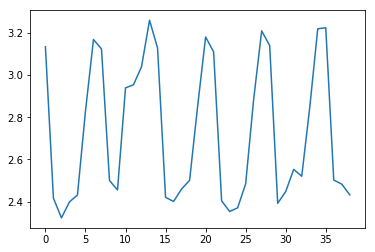

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.867203   
air_0164b9927d20bcc3_2017-04-23              1.409306   
air_0241aa3964b7f861_2017-04-23              2.364064   
air_0328696196e46f18_2017-04-23              2.139644   
air_034a3d5b40d5b1b1_2017-04-23              3.512494   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.470171  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.093115  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.634084  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.496411  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.531788

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/l4_3001_lgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')